In [81]:
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_csv("datasets/diabetes.csv")

In [3]:
cols = [col for col in df.columns if col not in 'Outcome']

scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])

In [4]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=17)

# Random Forests

In [5]:
rf_model = RandomForestClassifier()
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [6]:
cv_result = cross_validate(rf_model, X_train, y_train, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print(f"test_accuracy \n {cv_result['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_result['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_result['test_roc_auc'].mean()}")

test_accuracy 
 0.773913043478261
test_f1 
 0.6647023915714618
test_roc_auc 
 0.8214877028397567


In [7]:
rf_params = {'max_depth': [5, 8, None],
            'max_features': [3, 5, 7, 'auto'],
            'min_samples_split': [2, 5, 8, 15, 20],
            'n_estimators': [100, 200, 500]}

In [8]:
rf_model2 = RandomForestClassifier()
result = GridSearchCV(rf_model2,
                     rf_params,
                     cv=10,
                      n_jobs=-1,
                      verbose=True).fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


In [9]:
result.best_params_

{'max_depth': 8,
 'max_features': 3,
 'min_samples_split': 15,
 'n_estimators': 100}

In [11]:
rf_final = RandomForestClassifier(**result.best_params_).fit(X_train, y_train)
cv_results = cross_validate(rf_final,
                           X_train,
                           y_train,
                           cv=10,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7847826086956522
test_f1 
 0.68201759130299
test_roc_auc 
 0.8310982927653819


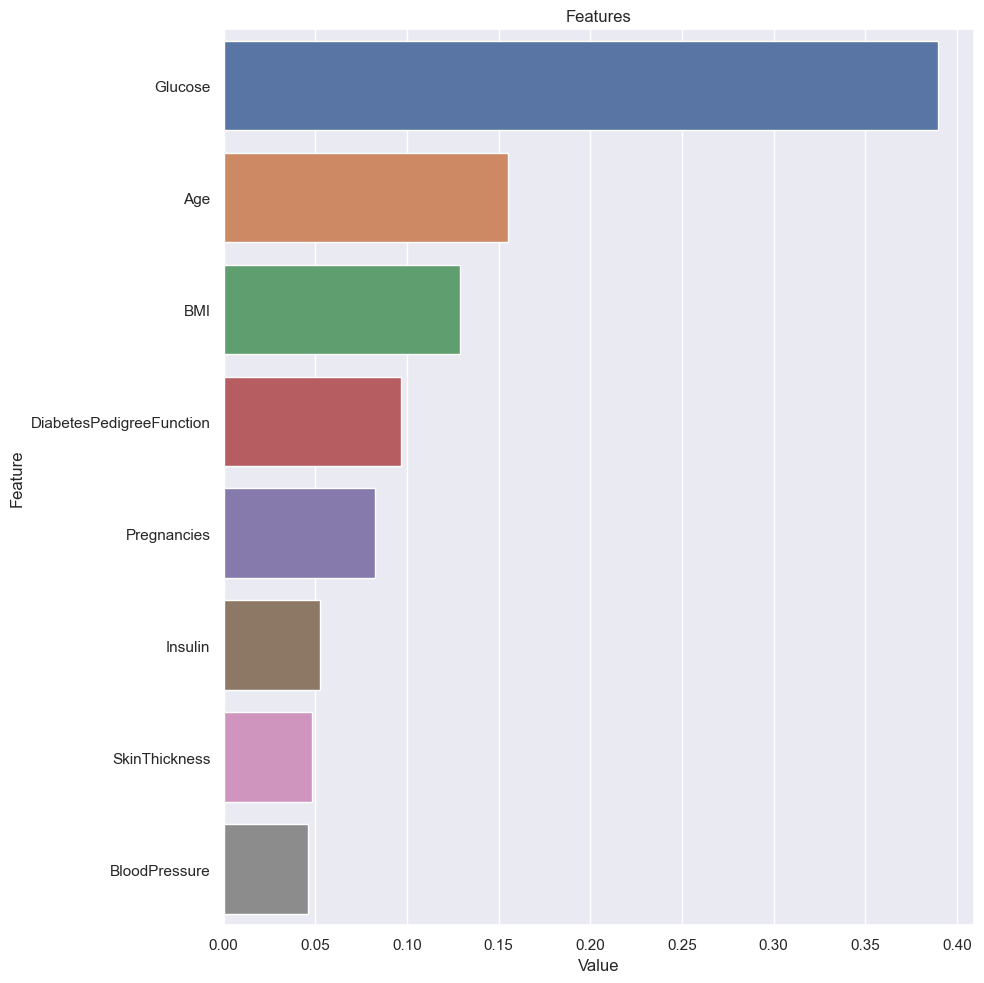

In [12]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X_train)

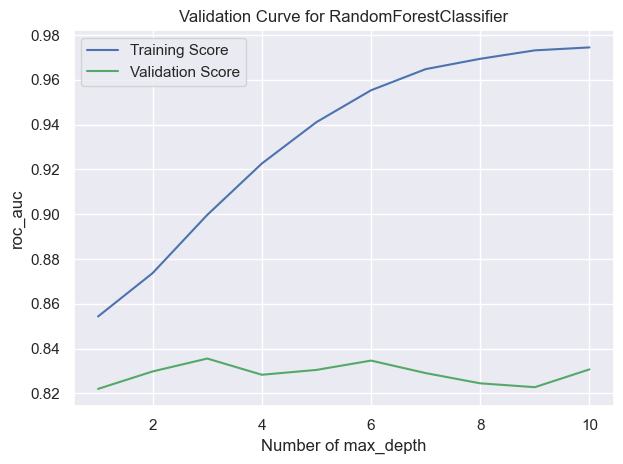

In [13]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X_train, y_train, "max_depth", range(1, 11), scoring="roc_auc")

# Gradient Boosting Classifier

In [14]:
gbm_model = GradientBoostingClassifier()
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [16]:
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7578728461081402
test_f1 
 0.6357217452232021
test_roc_auc 
 0.825530747728861


In [17]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [20]:
gbm_model2 = GradientBoostingClassifier()
gbm_best_grid = GridSearchCV(gbm_model2,
                             gbm_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [21]:
gbm_best_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.7}

In [23]:
gbm_final = GradientBoostingClassifier(**gbm_best_grid.best_params_).fit(X_train, y_train)
cv_results = cross_validate(gbm_final,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7760869565217392
test_f1 
 0.6692313362936237
test_roc_auc 
 0.8087845082177708


# eXtreme Gradient Boosting

In [24]:
xgboost_model = XGBClassifier()
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [27]:
cv_results = cross_validate(xgboost_model,
                           X_train,
                           y_train,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7434782608695653
test_f1 
 0.6251627309111143
test_roc_auc 
 0.7887482344632768


In [39]:
xgboost_params = {"learning_rate": [0.001, 0.01, 0.1],
              "max_depth": [5, 8, None],
              "n_estimators": [100, 500, 1000],
              "colsample_bytree": [None, 0.7, 1]}

In [40]:
xgboost_model2 = XGBClassifier()
xgboost_best_grid = GridSearchCV(xgboost_model2,
                             xgboost_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [41]:
xgboost_best_grid.best_params_

{'colsample_bytree': None,
 'learning_rate': 0.01,
 'max_depth': 8,
 'n_estimators': 500}

In [42]:
xgboost_final = XGBClassifier(**xgboost_best_grid.best_params_).fit(X_train, y_train)
cv_results = cross_validate(xgboost_final,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7695652173913043
test_f1 
 0.6643459573310798
test_roc_auc 
 0.8104498908577298


# LightGBM

In [47]:
lgbm_model = LGBMClassifier()
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [44]:
cv_results = cross_validate(lgbm_model,
                           X_train,
                           y_train,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

[LightGBM] [Info] Number of positive: 130, number of negative: 238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.353261 -> initscore=-0.604736
[LightGBM] [Info] Start training from score -0.604736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 129, number of negative: 239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [53]:
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

In [54]:
lgbm_model2 = LGBMClassifier()
lgbm_best_grid = GridSearchCV(lgbm_model2,
                             lgbm_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 162, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352174 -> initscore=-0.609497
[LightGBM] [Info] Start training from score -0.609497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [55]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'n_estimators': 350}

In [56]:
lgbm_final = LGBMClassifier(**lgbm_best_grid.best_params_).fit(X_train, y_train)
cv_results = cross_validate(lgbm_final,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

[LightGBM] [Info] Number of positive: 162, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352174 -> initscore=-0.609497
[LightGBM] [Info] Start training from score -0.609497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [61]:
lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]} 
#lgbm kullanıyorsak bu şekilde yüksek değerler denemeliyiz.

In [58]:
lgbm_model3 = LGBMClassifier(colsample_bytree=0.9, learning_rate=0.01)
lgbm_best_grid = GridSearchCV(lgbm_model3,
                             lgbm_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[LightGBM] [Info] Number of positive: 162, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.352174 -> initscore=-0.609497
[LightGBM] [Info] Start training from score -0.609497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [59]:
lgbm_best_grid.best_params_

{'n_estimators': 400}

In [ ]:
# lgbm_final = LGBMClassifier(**lgbm_best_grid.best_params_, colsample_bytree=0.9, learning_rate=0.01).fit(X_train, y_train)
cv_results = cross_validate(lgbm_final,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

# CatBoost

In [66]:
catboost_model = CatBoostClassifier(verbose=False)

In [67]:
cv_results = cross_validate(catboost_model,
                           X_train,
                           y_train,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7847826086956522
test_f1 
 0.6881507775524003
test_roc_auc 
 0.8268518875192605


In [70]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [71]:
catboost_model2 = CatBoostClassifier(verbose=False)
catboost_best_grid = GridSearchCV(catboost_model2,
                                 catboost_params,
                                 cv=5,
                                 n_jobs=-1,
                                 verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [72]:
catboost_best_grid.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.01}

In [75]:
catboost_final = CatBoostClassifier(**catboost_best_grid.best_params_, verbose=False).fit(X_train, y_train)
cv_results = cross_validate(catboost_final,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7891304347826088
test_f1 
 0.6817273954116059
test_roc_auc 
 0.8386647727272727


# Hyperparameter Optimization with RandomSearchCV 

In [77]:
rf_model = RandomForestClassifier()

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

Denenecek parametreler fazla olduğunda öncelikle RandomSearchCV ile parametreler bulunup sonrasında etrafındaki değerler eklenerek tekrardan GridSearchCV uygulanması iyi olur.

In [78]:
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               n_jobs=-1).fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [79]:
rf_random.best_params_

{'n_estimators': 1211,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 11}

In [80]:
rf_final = RandomForestClassifier(**rf_random.best_params_).fit(X_train, y_train)
cv_results = cross_validate(rf_final,
                           X_train,
                           y_train,
                           cv=5,
                           scoring=["accuracy", "f1", "roc_auc"])

print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
print(f"test_f1 \n {cv_results['test_f1'].mean()}")
print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

test_accuracy 
 0.7869565217391303
test_f1 
 0.6855546995377504
test_roc_auc 
 0.8291854455572676


# Analyzing Model Complexity with Learning Curves

In [82]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

In [83]:
rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]

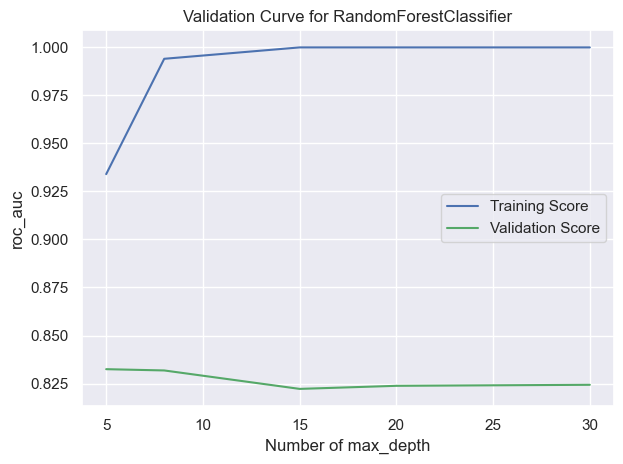

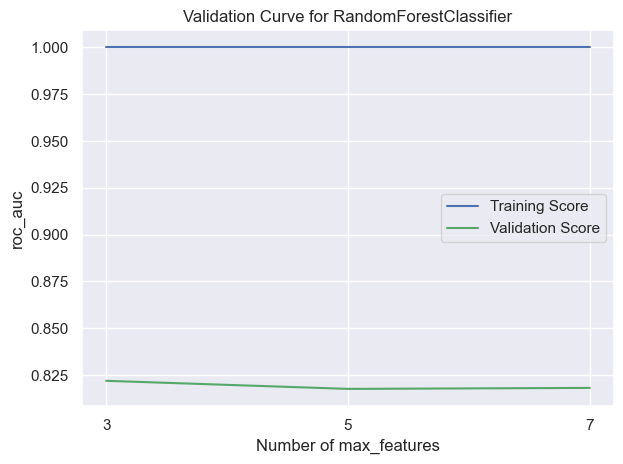

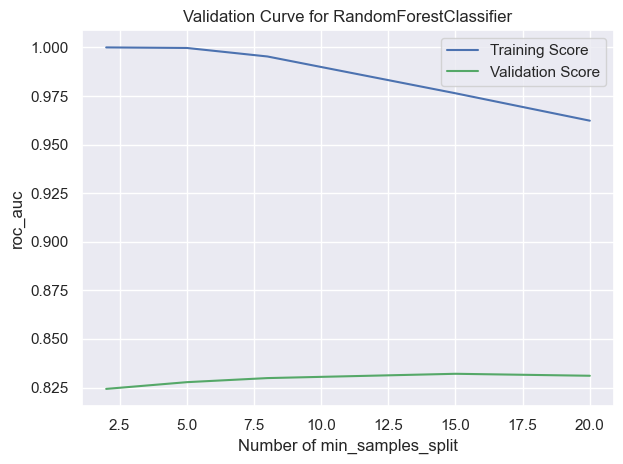

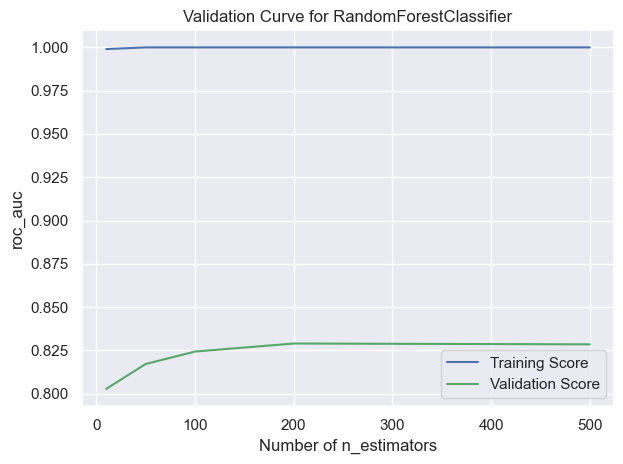

In [84]:
rf_model = RandomForestClassifier(random_state=17)

for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])